In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [5]:
# Load the model files (downloaded beforehand)
prototxt = 'colorization_deploy_v2.prototxt'
model = 'colorization_release_v2.caffemodel'
pts = 'pts_in_hull.npy'


In [9]:
# Load the cluster centers
net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts = np.load(pts)


In [10]:
# Add the cluster centers to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype(np.float32)]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [14]:
# Load your grayscale image
img_path = "bw_image.jpeg"  # Replace with your image path
bw_img = cv2.imread(img_path)
bw_img = cv2.cvtColor(bw_img, cv2.COLOR_BGR2GRAY)
bw_img = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB)
h, w = bw_img.shape[:2]

In [15]:
# Resize to network input size
img_rs = cv2.resize(bw_img, (224, 224))
img_lab = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
l_channel = img_lab[:, :, 0] - 50  # Mean-centering


In [16]:
# Prepare input
net_input = cv2.dnn.blobFromImage(l_channel)
net.setInput(net_input)
ab_channels = net.forward()[0, :, :, :].transpose((1, 2, 0))


In [17]:
# Resize ab channels to original image size
ab_channels_us = cv2.resize(ab_channels, (w, h))


In [18]:
# Combine with original L channel
bw_img_lab = cv2.cvtColor(bw_img, cv2.COLOR_RGB2Lab)
colorized = np.zeros((h, w, 3), dtype=np.float32)
colorized[:, :, 0] = bw_img_lab[:, :, 0]
colorized[:, :, 1:] = ab_channels_us

In [19]:
# Convert back to RGB
colorized = cv2.cvtColor(colorized.astype(np.uint8), cv2.COLOR_Lab2RGB)


(-0.5, 180.5, 147.5, -0.5)

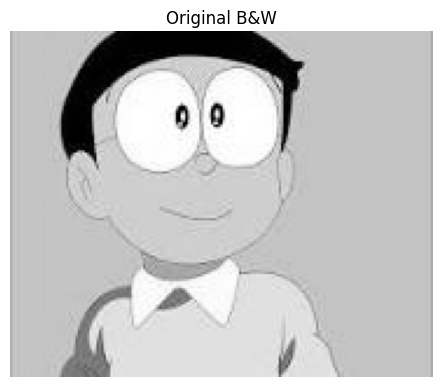

In [20]:
# Show result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original B&W')
plt.imshow(bw_img)
plt.axis('off')

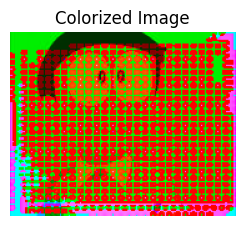

In [21]:
plt.subplot(1, 2, 2)
plt.title('Colorized Image')
plt.imshow(colorized)
plt.axis('off')
plt.show()